# Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import optuna 
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient
import joblib
from sklearn.dummy import DummyRegressor


pd.options.mode.chained_assignment = None

plt.close('all')

C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Préparation

### Principaux fichiers

In [2]:
air_visit = pd.read_csv('air_visit_data.csv')
air_store = pd.read_csv('air_store_info.csv')
air_reserve = pd.read_csv('air_reserve.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
store_relation = pd.read_csv('store_id_relation.csv')
date_info =pd.read_csv("date_info.csv")

### Agrégation des données

In [3]:
# Air réservations
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date
air_reserve_agg = air_reserve.groupby(['air_store_id', 'visit_date']).agg({
    'reserve_visitors': 'sum',
    'reserve_datetime': 'count'
}).reset_index()
air_reserve_agg.columns = ['air_store_id', 'visit_date', 'total_reserved_air', 'nb_res_air']

# HPG réservations (jointure)
hpg_reserve['visit_date'] = pd.to_datetime(hpg_reserve['visit_datetime']).dt.date
hpg_reserve = hpg_reserve.merge(store_relation, on='hpg_store_id', how='left')
hpg_reserve_agg = hpg_reserve.groupby(['air_store_id', 'visit_date']).agg({
    'reserve_visitors': 'sum',
    'reserve_datetime': 'count'
}).reset_index()
hpg_reserve_agg.columns = ['air_store_id', 'visit_date', 'total_reserved_hpg', 'nb_res_hpg']


### Mise en place du data set final

In [4]:
# Jointures des jeux de données importants 
df = air_visit.merge(air_reserve_agg, on=['air_store_id', 'visit_date'], how='left')
df = df.merge(hpg_reserve_agg, on=['air_store_id', 'visit_date'], how='left')
df = df.merge(air_store, on='air_store_id', how='left')
df = df.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')

# Gestion des valeurs nulles // vides 
df['total_reserved_air'] = df['total_reserved_air'].fillna(0)
df['total_reserved_hpg'] = df['total_reserved_hpg'].fillna(0)
df['nb_res_air'] = df['nb_res_air'].fillna(0)
df['nb_res_hpg'] = df['nb_res_hpg'].fillna(0)

# Total des réservations
df['total_reserved'] = df['total_reserved_air'] + df['total_reserved_hpg']
df['nb_reservations'] = df['nb_res_air'] + df['nb_res_hpg']

# Features temporelles
df['visit_date'] = pd.to_datetime(df['visit_date'])
df['weekday'] = df['visit_date'].dt.weekday
df['month'] = df['visit_date'].dt.month
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['holiday'] = df['holiday_flg'].astype(int)

print(f"Le jeu de données final a {len(df)} lignes")


Le jeu de données final a 252108 lignes


# Analyse Exploratoire des Données

In [5]:
df.head()

,air_store_id,visit_date,visitors,total_reserved_air,nb_res_air,total_reserved_hpg,nb_res_hpg,air_genre_name,air_area_name,latitude,longitude,calendar_date,day_of_week,holiday_flg,total_reserved,nb_reservations,weekday,month,is_weekend,holiday
0,air_ba937bf13d40fb24,2016-01-13,25,0.0,0.0,0.0,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-13,Wednesday,0,0.0,0.0,2,1,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,0.0,0.0,0.0,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-14,Thursday,0,0.0,0.0,3,1,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0.0,0.0,0.0,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-15,Friday,0,0.0,0.0,4,1,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,0.0,0.0,0.0,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-16,Saturday,0,0.0,0.0,5,1,1,0
4,air_ba937bf13d40fb24,2016-01-18,6,0.0,0.0,0.0,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-18,Monday,0,0.0,0.0,0,1,0,0


In [6]:
# Tous les genres
df['air_genre_name'].value_counts()


air_genre_name
Izakaya                         62052
Cafe/Sweets                     52764
Dining bar                      34192
Italian/French                  30011
Bar/Cocktail                    25135
Japanese food                   18789
Other                            8246
Yakiniku/Korean food             7025
Western food                     4897
Creative cuisine                 3868
Okonomiyaki/Monja/Teppanyaki     3706
Asian                             535
Karaoke/Party                     516
International cuisine             372
Name: count, dtype: int64

### Choix des données : uniquement la restauration classique assise (Plat + Entrée + Dessert)

In [7]:
# Italian/French + Japanese food + Yakiniku/Korean food + Western food + International cuisine
a_garder = [
    'Italian/French',
    'Japanese food',
    'Yakiniku/Korean food',
    'Western food',
    'International cuisine'
]


df_new = df[df['air_genre_name'].isin(a_garder)].reset_index(drop=True)

print(df_new['air_genre_name'].value_counts())
print(df_new.shape)


air_genre_name
Italian/French           30011
Japanese food            18789
Yakiniku/Korean food      7025
Western food              4897
International cuisine      372
Name: count, dtype: int64
(61094, 20)


### Le jeu de données final utilisé pour le reste du travail est df_new

In [8]:
df_new.head()

,air_store_id,visit_date,visitors,total_reserved_air,nb_res_air,total_reserved_hpg,nb_res_hpg,air_genre_name,air_area_name,latitude,longitude,calendar_date,day_of_week,holiday_flg,total_reserved,nb_reservations,weekday,month,is_weekend,holiday
0,air_9438d67241c81314,2016-01-04,34,0.0,0.0,0.0,0.0,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,2016-01-04,Monday,0,0.0,0.0,0,1,0,0
1,air_9438d67241c81314,2016-01-05,25,0.0,0.0,0.0,0.0,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,2016-01-05,Tuesday,0,0.0,0.0,1,1,0,0
2,air_9438d67241c81314,2016-01-06,41,0.0,0.0,0.0,0.0,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,2016-01-06,Wednesday,0,0.0,0.0,2,1,0,0
3,air_9438d67241c81314,2016-01-07,30,0.0,0.0,0.0,0.0,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,2016-01-07,Thursday,0,0.0,0.0,3,1,0,0
4,air_9438d67241c81314,2016-01-08,47,0.0,0.0,0.0,0.0,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,2016-01-08,Friday,0,0.0,0.0,4,1,0,0


In [9]:
df_new.columns

Index(['air_store_id', 'visit_date', 'visitors', 'total_reserved_air',
       'nb_res_air', 'total_reserved_hpg', 'nb_res_hpg', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'calendar_date',
       'day_of_week', 'holiday_flg', 'total_reserved', 'nb_reservations',
       'weekday', 'month', 'is_weekend', 'holiday'],
      dtype='object')

### Informations générales sur le df_new

In [10]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61094 entries, 0 to 61093
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   air_store_id        61094 non-null  object        
 1   visit_date          61094 non-null  datetime64[ns]
 2   visitors            61094 non-null  int64         
 3   total_reserved_air  61094 non-null  float64       
 4   nb_res_air          61094 non-null  float64       
 5   total_reserved_hpg  61094 non-null  float64       
 6   nb_res_hpg          61094 non-null  float64       
 7   air_genre_name      61094 non-null  object        
 8   air_area_name       61094 non-null  object        
 9   latitude            61094 non-null  float64       
 10  longitude           61094 non-null  float64       
 11  calendar_date       61094 non-null  object        
 12  day_of_week         61094 non-null  object        
 13  holiday_flg         61094 non-null  int64     

In [11]:
df_new.describe()

,visit_date,visitors,total_reserved_air,nb_res_air,total_reserved_hpg,nb_res_hpg,latitude,longitude,holiday_flg,total_reserved,nb_reservations,weekday,month,is_weekend,holiday
count,61094,61094.000000,61094.0,61094.0,61094.0,61094.0,61094.000000,61094.000000,61094.000000,61094.0,61094.0,61094.000000,61094.000000,61094.000000,61094.000000
mean,2016-10-13 21:24:30.429174528,21.487135,0.0,0.0,0.0,0.0,35.872980,137.920835,0.047795,0.0,0.0,3.004043,6.228353,0.266245,0.047795
min,2016-01-01 00:00:00,1.000000,0.0,0.0,0.0,0.0,33.211967,130.348436,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000
25%,2016-07-25 00:00:00,10.000000,0.0,0.0,0.0,0.0,34.710895,135.509801,0.000000,0.0,0.0,1.000000,3.000000,0.000000,0.000000
50%,2016-10-24 00:00:00,18.000000,0.0,0.0,0.0,0.0,35.661777,139.704051,0.000000,0.0,0.0,3.000000,7.000000,0.000000,0.000000
75%,2017-01-25 00:00:00,30.000000,0.0,0.0,0.0,0.0,35.694003,139.753595,0.000000,0.0,0.0,5.000000,10.000000,1.000000,0.000000
max,2017-04-22 00:00:00,305.000000,0.0,0.0,0.0,0.0,44.020632,144.273398,1.000000,0.0,0.0,6.000000,12.000000,1.000000,1.000000
std,NaN,16.077222,0.0,0.0,0.0,0.0,2.248384,3.471290,0.213334,0.0,0.0,1.894073,3.681284,0.441998,0.213334


### Détection des outliers en fonction de la méthode des quartiles

In [12]:
# IQR pour visitors
Q1 = df_new['visitors'].quantile(0.25)
Q3 = df_new['visitors'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR  # ~4
upper_bound = Q3 + 1.5 * IQR  # ~36

outliers_iqr = df_new[(df_new['visitors'] < lower_bound) | (df_new['visitors'] > upper_bound)]
print(f"Outliers IQR: {len(outliers_iqr)} / {len(df_new)} ({len(outliers_iqr)/len(df_new)*100:.1f}%)")
print(outliers_iqr[['visitors', 'weekday', 'is_weekend']].head())


Outliers IQR: 1553 / 61094 (2.5%)
     visitors  weekday  is_weekend
122        62        4           0
343        61        3           0
349        82        2           0
370        64        4           0
448        61        4           0


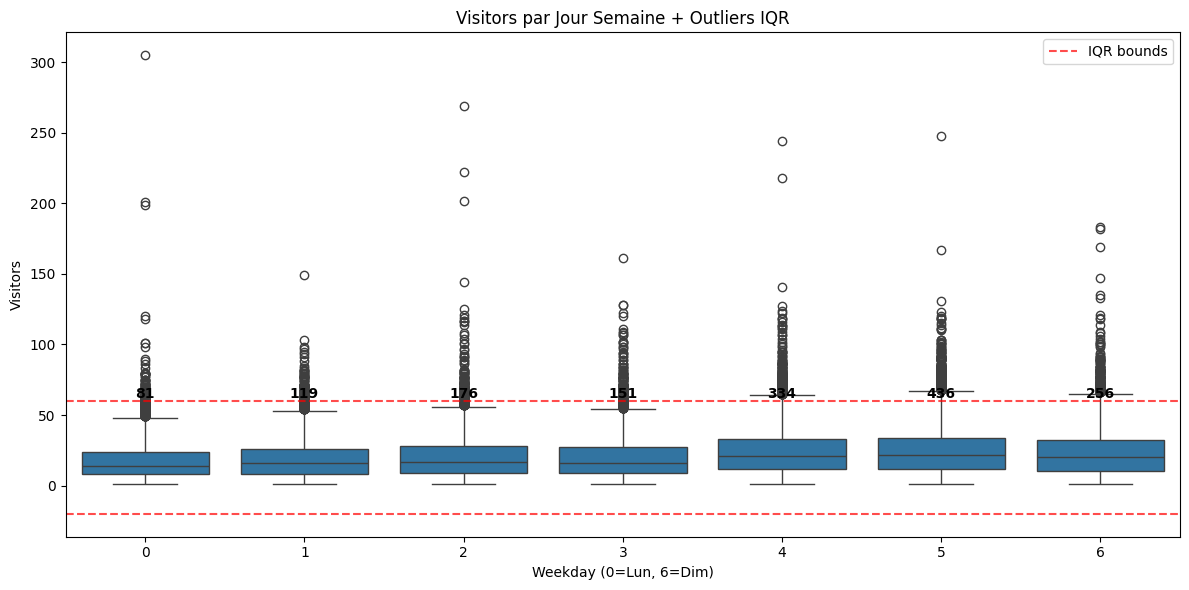

Outliers par jour:
         count  mean
weekday             
0           81  78.0
1          119  70.5
2          176  75.1
3          151  75.2
4          334  73.9
5          436  74.5
6          256  75.0


In [13]:
# Boxplot OUTLIERS par jour de la semaine
plt.figure(figsize=(12, 6))

# Boxplot par weekday avec outliers mis en évidence
sns.boxplot(data=df_new, x='weekday', y='visitors')

# Lignes seuils IQR global
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.7, label=f'IQR bounds')
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.7)

# Compter outliers par jour
outliers_par_jour = outliers_iqr['weekday'].value_counts().sort_index()
for i, count in outliers_par_jour.items():
    plt.text(i, upper_bound + 2, f'{count}', ha='center', fontweight='bold')

plt.title('Visitors par Jour Semaine + Outliers IQR')
plt.xlabel('Weekday (0=Lun, 6=Dim)')
plt.ylabel('Visitors')
plt.legend()
plt.tight_layout()
plt.show()

print("Outliers par jour:")
print(outliers_iqr.groupby('weekday')['visitors'].agg(['count', 'mean']).round(1))


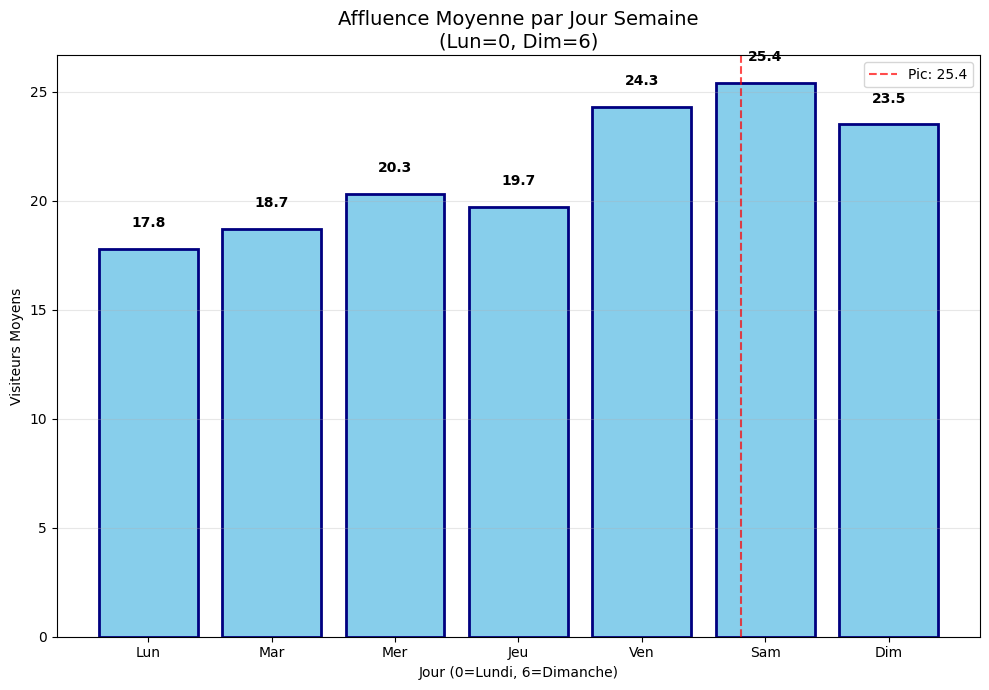

weekday
0    17.8
1    18.7
2    20.3
3    19.7
4    24.3
5    25.4
6    23.5
Name: visitors, dtype: float64


In [14]:
# Affluence moyenne par jour de la semaine
plt.figure(figsize=(10, 7))

# Barplot moyen
weekday_means = df_new.groupby('weekday')['visitors'].mean().round(1)
plt.bar(weekday_means.index, weekday_means.values, color='skyblue', edgecolor='navy', linewidth=2)

# Annotations
for i, v in enumerate(weekday_means.values):
    plt.text(i, v+1, f'{v}', ha='center', fontweight='bold')

plt.title('Affluence Moyenne par Jour Semaine\n(Lun=0, Dim=6)', fontsize=14)
plt.xlabel('Jour (0=Lundi, 6=Dimanche)')
plt.ylabel('Visiteurs Moyens')
plt.xticks(range(7), ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'])
plt.grid(axis='y', alpha=0.3)

# Pic week-end
max_day = weekday_means.idxmax()
plt.axvline(max_day-0.2, color='red', linestyle='--', alpha=0.7, label=f'Pic: {weekday_means[max_day]:.1f}')

plt.legend()
plt.tight_layout()
plt.show()

print(weekday_means)

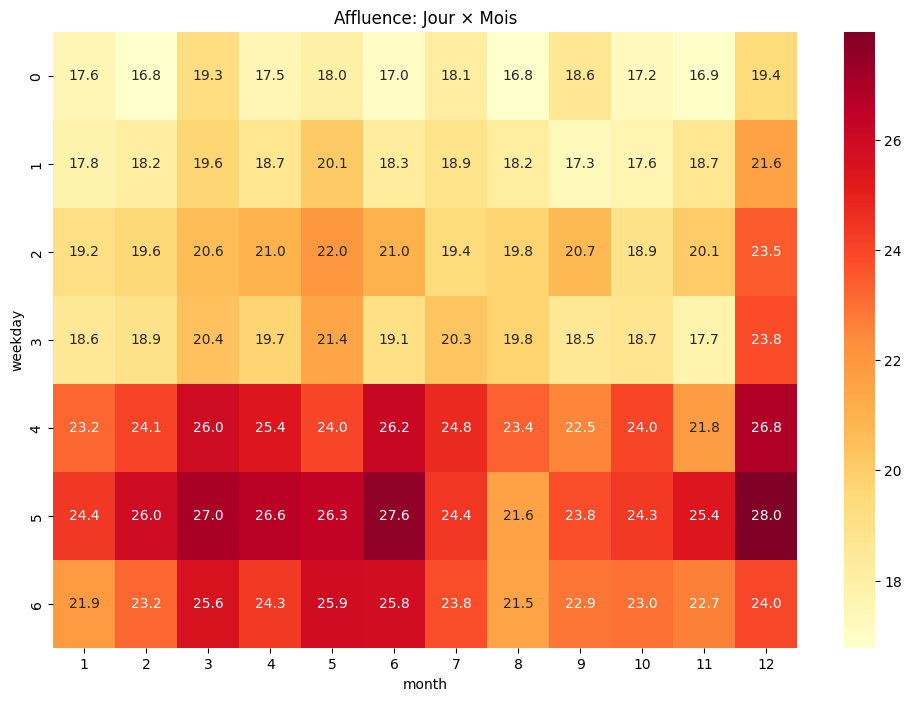

In [15]:
pivot = df_new.pivot_table('visitors', 'weekday', 'month', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Affluence: Jour × Mois')
plt.show()


# Feature eng

### NB: Lag1 = visiteurs de la veille, Lag2 = visiteurs d'avant hier, ...

In [16]:
# Trier par store et date
df_new['visit_date'] = pd.to_datetime(df_new['visit_date'])
df_new = df_new.sort_values(['air_store_id', 'visit_date']).reset_index(drop=True)

# Lags et rolling
df_new['visitors_lag1'] = df_new.groupby('air_store_id')['visitors'].shift(1)
df_new['visitors_lag7'] = df_new.groupby('air_store_id')['visitors'].shift(7)
df_new['visitors_mean_7'] = df_new.groupby('air_store_id')['visitors'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)


In [17]:
# Suppression des valeurs NaN
sans_nan = df_new.dropna().reset_index(drop=True)
sans_nan.head()


,air_store_id,visit_date,visitors,total_reserved_air,nb_res_air,total_reserved_hpg,nb_res_hpg,air_genre_name,air_area_name,latitude,...,holiday_flg,total_reserved,nb_reservations,weekday,month,is_weekend,holiday,visitors_lag1,visitors_lag7,visitors_mean_7
0,air_00a91d42b08b08d9,2016-07-09,11,0.0,0.0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,0.0,0.0,5,7,1,0,42.0,35.0,24.285714
1,air_00a91d42b08b08d9,2016-07-11,25,0.0,0.0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,0.0,0.0,0,7,0,0,11.0,9.0,26.571429
2,air_00a91d42b08b08d9,2016-07-12,24,0.0,0.0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,0.0,0.0,1,7,0,0,25.0,20.0,27.142857
3,air_00a91d42b08b08d9,2016-07-13,36,0.0,0.0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,0.0,0.0,2,7,0,0,24.0,25.0,28.714286
4,air_00a91d42b08b08d9,2016-07-14,28,0.0,0.0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,0.0,0.0,3,7,0,0,36.0,29.0,28.571429


### Vérification de la qualité des Lags afin de vérifier si la corrélation est cohérente, s'il y a des soucis de gestion des données

In [18]:
# Regard sur la corrélation
sans_nan[['visitors', 'visitors_lag1', 'visitors_lag7', 'visitors_mean_7']].corr()

,visitors,visitors_lag1,visitors_lag7,visitors_mean_7
visitors,1.000000,0.530948,0.549966,0.745503
visitors_lag1,0.530948,1.000000,0.567353,0.738961
visitors_lag7,0.549966,0.567353,1.000000,0.658452
visitors_mean_7,0.745503,0.738961,0.658452,1.000000


In [19]:
# Exemple par store
sans_nan[sans_nan['air_store_id'] == sans_nan['air_store_id'].iloc[0]][
    ['visit_date', 'visitors', 'visitors_lag1', 'visitors_lag7', 'visitors_mean_7']
].head(10)


,visit_date,visitors,visitors_lag1,visitors_lag7,visitors_mean_7
0,2016-07-09,11,42.0,35.0,24.285714
1,2016-07-11,25,11.0,9.0,26.571429
2,2016-07-12,24,25.0,20.0,27.142857
3,2016-07-13,36,24.0,25.0,28.714286
4,2016-07-14,28,36.0,29.0,28.571429
5,2016-07-15,28,28.0,34.0,27.714286
6,2016-07-16,5,28.0,42.0,22.428571
7,2016-07-19,25,5.0,11.0,24.428571
8,2016-07-20,19,25.0,25.0,23.571429
9,2016-07-21,47,19.0,24.0,26.857143


### On obtient des corrélations élevées (>0.5); ce quqi montre que les features sont bien capturées

# SPLIT Train/Test (80/20) et Baseline 

In [20]:
features = ['total_reserved', 'nb_reservations', 'weekday', 'month', 'is_weekend', 
            'holiday']

X = df_new[features].fillna(0)
y = df_new['visitors']

split = int(0.8 * len(X))

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f" Train: {len(X_train)} | Test: {len(X_test)}")
print("Features OK:", len(features))


 Train: 48875 | Test: 12219
Features OK: 6


### XGBoost

In [21]:
def metriques_completes(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}

In [22]:
# XGBoost V1
model_v1 = xgb.XGBRegressor(
    n_estimators=200, max_depth=6, learning_rate=0.1, 
    random_state=42, verbosity=0
)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

# Métriques V1
print("XGBoost V1:")
for metrique, valeur in metriques_completes(y_test, y_pred_v1).items():
    print(f"  {metrique}: {valeur:.3f}")


XGBoost V1:
  RMSE: 16.332
  MAE: 12.726
  R²: 0.021


In [23]:
# Ajout Features V2
df_new['visit_date'] = pd.to_datetime(df_new['visit_date'])
df_new = df_new.sort_values(['air_store_id', 'visit_date']).reset_index(drop=True)

# Lags
df_new['visitors_lag1'] = df_new.groupby('air_store_id')['visitors'].shift(1).fillna(0)
df_new['visitors_lag7'] = df_new.groupby('air_store_id')['visitors'].shift(7).fillna(0)
df_new['visitors_mean_7'] = df_new.groupby('air_store_id')['visitors'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)

# Cluster simple
store_coords = df_new.groupby('air_store_id')[['latitude', 'longitude']].mean()
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
store_coords['cluster'] = kmeans.fit_predict(store_coords[['latitude', 'longitude']])
df_new = df_new.merge(store_coords[['cluster']], left_on='air_store_id', right_index=True, how='left')

# Res moyennes store
df_new['res_mean_store'] = df_new.groupby('air_store_id')['total_reserved'].transform('mean')

# Features V2
features_v2 = ['total_reserved', 'nb_reservations', 'weekday', 'month', 'is_weekend', 
               'holiday', 'visitors_lag1', 'visitors_lag7', 'visitors_mean_7', 
               'cluster', 'res_mean_store']
X_v2 = df_new[features_v2].fillna(0)
split = int(0.8 * len(X_v2))
X_train_v2, X_test_v2 = X_v2.iloc[:split], X_v2.iloc[split:]
y_train, y_test = df_new['visitors'].iloc[:split], df_new['visitors'].iloc[split:]

print(f"V2 - Train: {len(X_train_v2)} | Features: {len(features_v2)}")

# XGBoost V2
model_v2 = xgb.XGBRegressor(n_estimators=150, max_depth=6, learning_rate=0.1, random_state=42)
model_v2.fit(X_train_v2, y_train)
y_pred_v2 = model_v2.predict(X_test_v2)

# Métriques V2
print("XGBoost V2:")
for metrique, valeur in metriques_completes(y_test, y_pred_v2).items():
    print(f"  {metrique}: {valeur:.3f}")


V2 - Train: 48875 | Features: 11
XGBoost V2:
  RMSE: 10.525
  MAE: 7.098
  R²: 0.593


### Comparaison V1 // V2

In [24]:
resultats = {
    'Modèle': ['XGBoost V1', 'XGBoost V2'],
    'Features': [6, 11],
    'RMSE': [16.332, 10.525],
    'MAE': [12.726, 7.098],
    'R²': [0.021, 0.593]
}

df_comparatif = pd.DataFrame(resultats).round(3)
df_comparatif



,Modèle,Features,RMSE,MAE,R²
0,XGBoost V1,6,16.332,12.726,0.021
1,XGBoost V2,11,10.525,7.098,0.593


# Prédictions

In [25]:
# Création des dates futures
max_date = df_new['visit_date'].max()
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=31, freq='D')
print(f"Prédictions: {future_dates[0].date()} → {future_dates[-1].date()}")

Prédictions: 2017-04-23 → 2017-05-23


In [26]:
# Features temporelles
future_df = pd.DataFrame({'visit_date': future_dates})
future_df['weekday'] = future_df['visit_date'].dt.weekday
future_df['month'] = future_df['visit_date'].dt.month
future_df['is_weekend'] = (future_df['weekday'] >= 5).astype(int)
future_df['holiday'] = 0

In [27]:
# stores
unique_stores = df_new['air_store_id'].unique()
future_df = future_df.loc[future_df.index.repeat(len(unique_stores))].reset_index(drop=True)
future_df['air_store_id'] = np.tile(unique_stores, 31)

In [28]:
# 4. Features moyennes stores (en fonction des donées présentes dans les data sets initials)
store_means = df_new.groupby('air_store_id')[features_v2].mean()
future_df = future_df.merge(store_means, left_on='air_store_id', right_index=True, how='left', suffixes=('', '_mean'))

In [29]:
# X_future avec NOMS EXACTS (pas de _mean en trop)
feature_names_v2 = ['total_reserved', 'nb_reservations', 'weekday', 'month', 
                    'is_weekend', 'holiday', 'visitors_lag1', 'visitors_lag7', 
                    'visitors_mean_7', 'cluster', 'res_mean_store']

X_future = future_df[feature_names_v2].fillna(0)

# Vérif
print("Colonnes X_future:", X_future.columns.tolist())
print("Match model_v2:", list(X_future.columns) == model_v2.feature_names_in_)
assert len(X_future.columns) == len(model_v2.feature_names_in_), "Mismatch!"

# Prédire
future_df['visitors_pred'] = model_v2.predict(X_future)


Colonnes X_future: ['total_reserved', 'nb_reservations', 'weekday', 'month', 'is_weekend', 'holiday', 'visitors_lag1', 'visitors_lag7', 'visitors_mean_7', 'cluster', 'res_mean_store']
Match model_v2: [ True  True  True  True  True  True  True  True  True  True  True]


In [30]:
# 6. Résultats agrégés (moyennes tous stores)
resultats_mai = future_df.groupby('visit_date')['visitors_pred'].agg(['mean', 'min', 'max']).round(0).reset_index()
resultats_mai.columns = ['date', 'visiteurs_moy', 'min_store', 'max_store']
print(" Prédictions MAI 2017:")
print(resultats_mai.head(10).round(0))

 Prédictions MAI 2017:
        date  visiteurs_moy  min_store  max_store
0 2017-04-23           22.0        5.0       80.0
1 2017-04-24           18.0        4.0       67.0
2 2017-04-25           19.0        4.0       68.0
3 2017-04-26           21.0        5.0       82.0
4 2017-04-27           20.0        4.0       80.0
5 2017-04-28           24.0        5.0       73.0
6 2017-04-29           26.0        6.0       74.0
7 2017-04-30           22.0        5.0       80.0
8 2017-05-01           18.0        4.0       67.0
9 2017-05-02           19.0        4.0       68.0


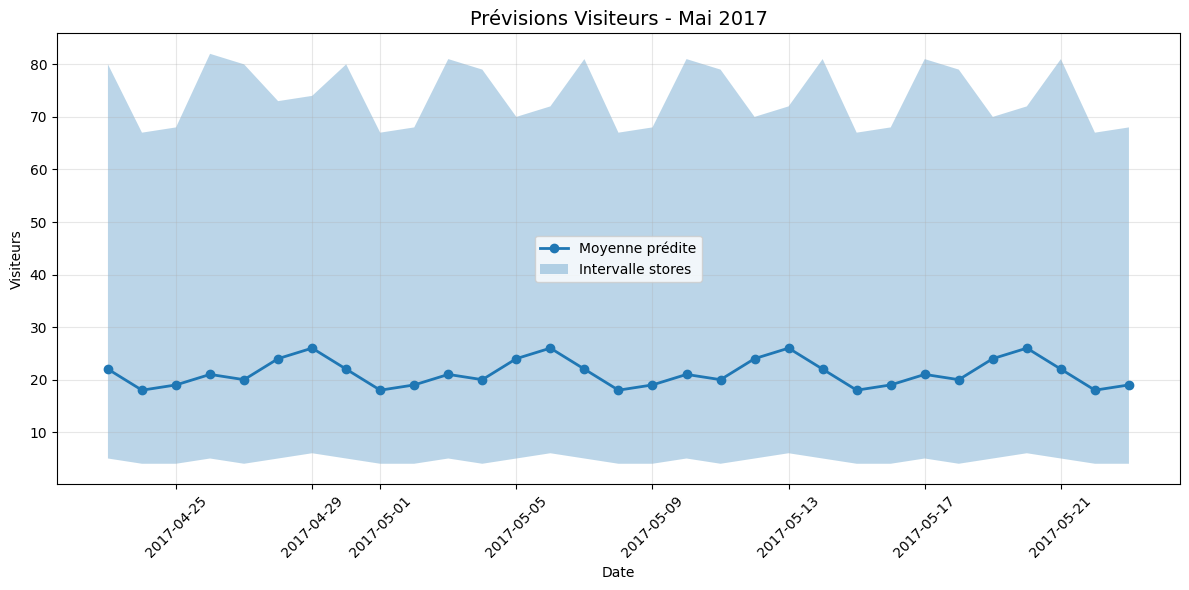

In [31]:
# Visualisation

plt.figure(figsize=(12, 6))
plt.plot(resultats_mai['date'], resultats_mai['visiteurs_moy'], marker='o', linewidth=2, label='Moyenne prédite')
plt.fill_between(resultats_mai['date'], resultats_mai['min_store'], resultats_mai['max_store'], alpha=0.3, label='Intervalle stores')
plt.title('Prévisions Visiteurs - Mai 2017', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Visiteurs')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
resultats_mai.to_csv('predictions_mai_2017.csv', index=False)


# ML Flow

In [33]:
mlflow.end_run()

In [34]:
# Caractéristiques importantes
feature_imp = pd.DataFrame({
    "feature": features_v2,
    "importance": model_v2.feature_importances_
}).sort_values("importance", ascending=False)
feature_imp.to_csv("feature_importance_v2.csv", index=False)

# Résultats 
test_results = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred_v2,
    'error': y_test - y_pred_v2
})
test_results.to_csv("test_results_v2.csv", index=False)

# Input example + signature
input_example = X_test_v2.iloc[:5]
signature = mlflow.models.infer_signature(X_test_v2, y_pred_v2)

# MLflow FINAL
with mlflow.start_run(run_name="XGBoost_V2_Final"):
    # Log params
    mlflow.log_params({
        "model": "XGBoost",
        "n_estimators": model_v2.n_estimators,
        "max_depth": model_v2.max_depth,
        "learning_rate": model_v2.learning_rate,
        "features": len(features_v2),
        "split": "80_20"
    })
    
    # Log métriques V2
    mlflow.log_metric("R2", 0.593)
    mlflow.log_metric("MAE", 7.098)
    mlflow.log_metric("RMSE", 10.525)
    
    # Log modèle
    mlflow.xgboost.log_model(model_v2, "model")
    
    # Log artifacts
    mlflow.log_artifact("feature_importance_v2.csv")
    mlflow.log_artifact("test_results_v2.csv")



C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [10:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-win

# Optuna (hyperparamètres)

In [35]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_v2, y_train)
    y_pred = model.predict(X_test_v2)
    return np.sqrt(mean_squared_error(y_test, y_pred)) 

# Optuna + MLflow
mlflow.set_experiment("Optuna_V2")
with mlflow.start_run(run_name="Optuna_HPO_V2"):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    # Meilleur modèle
    best_params = study.best_params
    best_model = xgb.XGBRegressor(**best_params, random_state=42)
    best_model.fit(X_train_v2, y_train)
    
    # Métriques best
    best_pred = best_model.predict(X_test_v2)
    best_metrics = metriques_completes(y_test, best_pred)
    
    # Log best
    mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
    mlflow.log_metrics({f"best_{k}": v for k, v in best_metrics.items()})
    mlflow.xgboost.log_model(best_model, "best_optuna_model")
    
    print("Best RMSE:", study.best_value)
    print("Best params:", best_params)
    print("Best metrics:", best_metrics)


2026/01/20 10:43:38 INFO mlflow.tracking.fluent: Experiment with name 'Optuna_V2' does not exist. Creating a new experiment.
[I 2026-01-20 10:43:38,627] A new study created in memory with name: no-name-eb5999c2-024c-40a1-9f6a-0329ac7fe75a
[I 2026-01-20 10:43:39,469] Trial 0 finished with value: 10.70624392035282 and parameters: {'n_estimators': 251, 'max_depth': 7, 'learning_rate': 0.17293507288997348, 'subsample': 0.9665813678182702, 'colsample_bytree': 0.9692408822726003}. Best is trial 0 with value: 10.70624392035282.
[I 2026-01-20 10:43:41,624] Trial 1 finished with value: 10.982044743466854 and parameters: {'n_estimators': 474, 'max_depth': 8, 'learning_rate': 0.10984164141033166, 'subsample': 0.8658682537035757, 'colsample_bytree': 0.7615680016666931}. Best is trial 0 with value: 10.70624392035282.
[I 2026-01-20 10:43:43,631] Trial 2 finished with value: 10.557611685796822 and parameters: {'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.03913483708838372, 'subsample': 0.

Best RMSE: 10.285765281490255
Best params: {'n_estimators': 202, 'max_depth': 4, 'learning_rate': 0.07030494449446466, 'subsample': 0.824294716279996, 'colsample_bytree': 0.7824317702152089}
Best metrics: {'RMSE': np.float64(10.285765281490255), 'MAE': np.float64(7.047674644519229), 'R²': 0.6117399334907532}
